In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt

In [2]:
# Paths to grayscale and color folders
bw_path = "bw_images/"
color_path = "rgb_images/"

IMG_SIZE = 128
bw_images = []
color_images = []

# Load paired images
# Collect only 1000 matched image pairs
all_files = sorted(os.listdir(bw_path))[:1000]

for filename in all_files:
    bw_img_path = os.path.join(bw_path, filename)
    color_img_path = os.path.join(color_path, filename)

    bw_img = cv2.imread(bw_img_path, cv2.IMREAD_GRAYSCALE)
    color_img = cv2.imread(color_img_path)

    if bw_img is None or color_img is None:
        continue

    bw_img = cv2.resize(bw_img, (IMG_SIZE, IMG_SIZE))
    color_img = cv2.resize(color_img, (IMG_SIZE, IMG_SIZE))

    bw_img = bw_img.reshape(IMG_SIZE, IMG_SIZE, 1) / 255.0
    color_img = color_img / 255.0  # Normalize to [0, 1]

    bw_images.append(bw_img)
    color_images.append(color_img)


# Convert to NumPy arrays
bw_images = np.array(bw_images)
color_images = np.array(color_images)

In [3]:
# Train-test split
xtrain, xtest, ytrain, ytest = train_test_split(bw_images, color_images, test_size=0.2, random_state=42)

# Model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output: ab channels (normalized)

model.compile(optimizer='adam', loss='mse')
model.summary()


c:\Users\sumit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,299 (153.51 KB)

 Trainable params: 39,299 (153.51 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train
model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=64)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.0926 - val_loss: 0.0737
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 935ms/step - loss: 0.0674 - val_loss: 0.0420
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 941ms/step - loss: 0.0372 - val_loss: 0.0245
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0268 - val_loss: 0.0215
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0229 - val_loss: 0.0208
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0213 - val_loss: 0.0194
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 969ms/step - loss: 0.0205 - val_loss: 0.0201
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 993ms/step - loss: 0.0224 - val_loss: 0.0193
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 984ms/step - loss: 0.0230 - val_loss: 0.0197
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 959ms/step - loss: 0.0213 - val_loss: 0.0195


In [25]:
def show_colorization_result(model, xtest, ytest, index=0):
    # Get the test image and true color
    gray = xtest[index]       # (H, W, 1)
    true = ytest[index]       # (H, W, 3)

    # Predict
    pred = model.predict(xtest[index:index+1])[0]  # (H, W, 3)

    # Display
    plt.figure(figsize=(12, 4))

    # Grayscale
    plt.subplot(1, 3, 1)
    plt.imshow(gray.squeeze(), cmap='gray')
    plt.title("Input Grayscale")
    plt.axis('off')

    # Predicted color
    plt.subplot(1, 3, 2)
    plt.imshow(np.clip(pred, 0, 1))
    plt.title("Predicted Color")
    plt.axis('off')

    # True color
    plt.subplot(1, 3, 3)
    plt.imshow(np.clip(true, 0, 1))
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


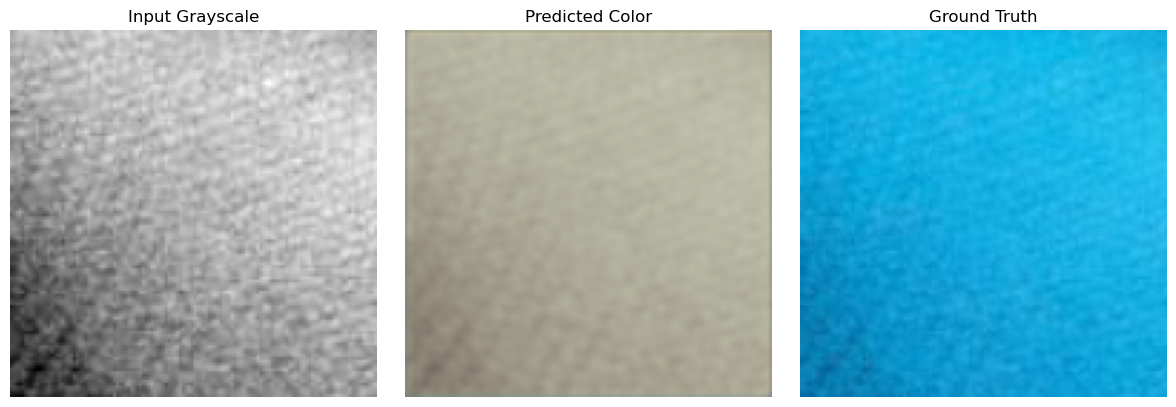

In [49]:
show_colorization_result(model, xtest, ytest, index=109)